# Прогнозирование оттока клиентов оператора связи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала и предоставила нам персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

**Цель исследования:**
- Построить модель машинного обучения для прогноза, уйдет клиент от оператора связи или нет.   


**Заказчику важно:**   
Во избежания убытков, перед бизнесом стоит задача свести к минимуму 2 основные метрики:  
1. Пользователю не предложили промокод и он ушел (*false negative*)
2. Пользователь не собирался уходить, но он пользуется предложенными промокодами (*false positive*)  
В связи с этим, мы будем опираться на значение метрики **AUC-ROC** — она учитывает возможность балансировать между *false posititve* и *false negative*. Её значение должно быть не менее отметки **0.85**.  
Также в качестве дополнительной метрики мы вычислим **accuracy** - долю правильных ответов модели.


**Ход исследования:**
- Загрузка и обзор предоставленных данных;
- Предобработка данных;
- Исследовательский анализ данных;
- Подготовка признаков для обучения модели;
- Обучение моделей с различными гиперпараметрами;
- Анализ моделей, выбор лучшей;
- Тестирование отобранной модели на тестовой выборке;
- Финальный вывод.


## Загрузка и обзор данных

In [ ]:
# Импортируем необходимые для работы библиотеки и функции
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve
)

#настройки
warnings.filterwarnings('ignore')

#константы
RANDOM_STATE = 270223

In [ ]:
def read_df(csv_file_name):
    """Функция для чтения данных из .csv файлов"""
    try:
        df = pd.read_csv(
            f'/content/drive/MyDrive/datasets/final_project/{csv_file_name}', 
            index_col = 'customerID')
    except:
        df = pd.read_csv(f'/datasets/final_provider/{csv_file_name}', 
                         index_col = 'customerID')
    return df

In [ ]:
# Прочитаем файлы и сохраним их в переменные
df_contract = read_df('contract.csv')
df_personal = read_df('personal.csv')
df_internet = read_df('internet.csv')
df_phone = read_df('phone.csv')

In [ ]:
def df_review(df):
    """Функция для краткого обзора данных"""
    # Получим общую информацию о таблице
    display(df.info())
    # Выведем на экран первые 5 строк таблицы
    display(df.head(5))
    # Получим числовое описание данных в таблице
    display(df.describe())


In [ ]:
print('Информация о договоре')
df_review(df_contract)

Информация о договоре
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
print('Персональные данные клиента')
df_review(df_personal)

Персональные данные клиента
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
print('Информация об интернет-услугах')
df_review(df_internet)

Информация об интернет-услугах
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [ ]:
print('Информация об услугах телефонии')
df_review(df_phone)

Информация об услугах телефонии
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


,MultipleLines
count,6361
unique,2
top,No
freq,3390


### Первые выводы

1. Нам предоставлены данные о более чем 7 000 клиентах оператора связи. При этом услугами телефонии пользуются 6 361 клиент, а услугами интернета - 5 517.  
2. Так как количество строк в датасетах разное, мы можем сказать, что в данных присутствуют пропуски. У некоторых признаков указан неверный тип данных. Присутствует нарушение стиля в названии признаков. Из первичного анализа аномальных значений не видно, нам предстоит провести проверку на следующем этапе.
3. Предварительно можно сказать, что дата заключения и окончания договора округлена до месяца. Из документации к данным нам известно, что данные были выгружены 1 февраля 2020 года. Более точные временные рамки мы постараемся вычислить на следующих этапах.
4. Предварительно мы можем сказать, что целевую переменную для построения нашей модели мы сгенерируем из признака `EndDate` -- дата окончания предоставления пользователю услуг.

Далее мы произведем предобработку данных, после чего проанализируем их.

## Предобработка данных

Из документации к данным нам известно, что во всех датасетах есть общий столбец `customerID`, который содержит код клиента. При чтении данных, мы взяли этот столбец за индекс. Объединим все датафреймы в один общий по индексу.

In [ ]:
df_full = pd.concat(
    [df_contract, df_personal, df_internet, df_phone], 
    axis=1, join='outer').reset_index()

Проверим общую таблицу на полные дубликаты:

In [ ]:
print(f'Количество дубликатов в данных: {df_full.duplicated().sum()}')

Количество дубликатов в данных: 0


Теперь изменим наименования колонок, согласно правилам хорошего стиля:

In [ ]:
# Создадим функцию, которая конвертирует стиль заголовка
def convert_to_snake_case(column):
    return ''.join(
        ['_' + i if i.isupper() else i for i in column]
        ).lstrip('_').lower()
df_full.columns = [convert_to_snake_case(c) for c in df_full.columns]

# Поправим названия пары колонок вручную
df_full = df_full.rename(columns={
    'streaming_t_v':'streaming_tv',
    'customer_i_d':'customer_id'}) 

# Для проверки выведем названия колонок на экран
df_full.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Далее мы рассмотрим каждый столбец по отдельности: построим графики, изучим пропуски, приведём к нужному типу данных там, где это необходимо, а также создадим дополнительные признаки.

Создадим функцию для быстрого описания данных.

In [ ]:
def data_review(colomn):
    print(f'Количество пропусков в данных: {colomn.isna().sum()}')    
    print(f'Тип данных: {colomn.dtypes}')
    print('Числовое описание данных:')
    print(colomn.describe())

### Дата начала и окончания пользования услугами

Для начала изучим колонки с **датой начала** пользования услугами оператора связи.

In [ ]:
data_review(df_full['begin_date'])

Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count           7043
unique            77
top       2014-02-01
freq             366
Name: begin_date, dtype: object


Пропуски в данных отсутствуют, но тип данных можно поменять на `datetime`. Затем вновь изучим числовое описание данных и построим гистраграмму. 

In [ ]:
df_full['begin_date'] = pd.to_datetime(df_full['begin_date'], format='%Y-%m-%d')

df_full['begin_date'].describe()

count                    7043
unique                     77
top       2014-02-01 00:00:00
freq                      366
first     2013-10-01 00:00:00
last      2020-02-01 00:00:00
Name: begin_date, dtype: object

Рассмотрим колонку с **датой окончания** предоставления услуг клиенту.

In [ ]:
data_review(df_full['end_date'])

Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7043
unique       5
top         No
freq      5174
Name: end_date, dtype: object


In [ ]:
df_full[df_full['end_date'] != 'No']['end_date'].sample(5)

6365    2019-11-01 00:00:00
3408    2019-10-01 00:00:00
365     2020-01-01 00:00:00
5458    2019-12-01 00:00:00
495     2019-11-01 00:00:00
Name: end_date, dtype: object

In [ ]:
df_full['end_date'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Пропусков в данных нет, но тип данных в колонке - `object`, а в качестве заглушки к пропускам стоит `No`.   
Также мы видим интересную особенность: в предоставленных данных договоры с оператором связи начали расторгать только с октября 2019 года, а уникальных значений в столбце всего 5 (включая заглушку).   
Исходя из этого мы можем сделать вывод, что **заказчик предоставил нам данные об активных и ушедших клиентах в период с 1 октября 2019 года по 1 февраля 2020 года**. 

Для начала мы выделим из этих данных целевую переменную: там, где присутствует дата расторжения договора, мы поставим 1 (`True`), где заглушка - 0 (`False`).  

Затем заменим заглушку на дату сбора данных, изменим тип данных на `datetime`.

После этого мы добавим новый признак -- сколько дней пользователь является клиентом оператора связи.

In [ ]:
# Создадим целевой признак
df_full['target'] = np.where(df_full['end_date'] == 'No', 0, 1)

# Заменим заглушку на дату сбора данных -- 1 февраля 2020 года
df_full.loc[df_full['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'

# Преобразуем тип данных на datetime
df_full['end_date'] = pd.to_datetime(df_full['end_date'], format='%Y-%m-%d')

# Создадим признак - время жизни пользователя в продукте в днях
df_full['lifetime_days'] = (df_full['end_date'] - df_full['begin_date']).dt.days

In [ ]:
print('Количество пользователей, отказавшихся от услуг связи за предоставленный период:', df_full['target'].sum())
df_full['end_date'].value_counts()

Количество пользователей, отказавшихся от услуг связи за предоставленный период: 1869


2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: end_date, dtype: int64

В предоставленных данных более 5 000 пользователей являются активными клиентами оператора связи. За указанный период отказались от услуг связи около 1900 клиентов. При этом распределение количества отказавшихся от услуг клиентов за указанный период примерно равное -- от 450 до 500 клиентов в месяц. Данные несбалансированные, но мы устраним это на этапе обучения моделей.

### Типы и методы оплат

Изучим колонки с информацией о типе и методах оплат. В наших данных их три:
- `type` - тип оплаты: ежемесячный, годовой и тд,
-	`paperless_billing` – безналичный расчет,
- `payment_method` – способ оплаты

In [ ]:
print('Тип оплаты')
data_review(df_full['type'])
print('')
print('Безналичный расчёт')
data_review(df_full['paperless_billing'])
print('')
print('Способ оплаты')
data_review(df_full['payment_method'])

Тип оплаты
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object

Безналичный расчёт
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7043
unique       2
top        Yes
freq      4171
Name: paperless_billing, dtype: object

Способ оплаты
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: payment_method, dtype: object


Пропусков в данных нет. Тип данных во всех трёх столбцах указан верно. Из трёх переменных только один признак бинарный (безналичный расчёт или нет). Выбросов или особенностей не наблюдаем.

In [ ]:
print('Ежемесячные траты на услуги')
data_review(df_full['monthly_charges'])
print('')
print('Всего потрачено на услуги')
data_review(df_full['total_charges'])
print('')

Ежемесячные траты на услуги
Количество пропусков в данных: 0
Тип данных: float64
Числовое описание данных:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

Всего потрачено на услуги
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7043
unique    6531
top           
freq        11
Name: total_charges, dtype: object



В колонке с общей суммой, потраченной на услуги связи, указан неверный тип данных. При этом значение моды -- пустая строка, и таких значений - 11 строк. Посмотрим на эти строки.



In [ ]:
df_full[df_full['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,lifetime_days
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Строки с пропущенным значением общей потраченной суммой - это новые клиенты, которые еще не совершили ни одного платежа. Так как таких строк немного, мы их исключим, а после этого переведём тип данных в `float`.

In [ ]:
df_full = df_full[df_full['total_charges'] != ' ']

df_full = df_full.astype({'total_charges': 'float', 'monthly_charges':'float'})

### Персональные данные клиента

In [ ]:
print('Пол клиента')
data_review(df_full['gender'])
print('')
print('Пенсионный возраст')
data_review(df_full['senior_citizen'])
print('')
print('Наличие супруга(и)')
data_review(df_full['partner'])
print('')
print('Наличие иждивенцев')
data_review(df_full['dependents'])
print('')

Пол клиента
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7032
unique       2
top       Male
freq      3549
Name: gender, dtype: object

Пенсионный возраст
Количество пропусков в данных: 0
Тип данных: int64
Числовое описание данных:
count    7032.000000
mean        0.162400
std         0.368844
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: senior_citizen, dtype: float64

Наличие супруга(и)
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7032
unique       2
top         No
freq      3639
Name: partner, dtype: object

Наличие иждивенцев
Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7032
unique       2
top         No
freq      4933
Name: dependents, dtype: object



Пропущенных значений в данных нет. В трёх из четырёх признаков тип данных -- `object`, все эти признаки бинарные. Мы закодируем эти признаки позже, перед обучением моделейи. Так как все остальные категориальные признаки в нашем датафрейме имеют тип `object`, для удобства мы приведём значения признака *Пенсионный возраст* в такой же формат.

In [ ]:
df_full['senior_citizen'] = np.where(df_full['senior_citizen'] == 0, 'No', 'Yes')

In [ ]:
data_review(df_full['senior_citizen'])

Количество пропусков в данных: 0
Тип данных: object
Числовое описание данных:
count     7032
unique       2
top         No
freq      5890
Name: senior_citizen, dtype: object


### Интернет-услуги и телефония

Мы достаточно подробно рассмотрели информацию об интернет-услугах и телефонии на первом шаге нашего исследования. Все признаки - бинарные, никаких особенностей здесь нет. На данном этапе мы:
- Добавим дополнительный признак: является клиент пользователем интернета или нет. Если id клиента было в таблице с информацией об интернет-услугах -- значит клиент пользовался интернетом (так как в первоначальном датасете с информацией об интернет-услугах пропусков не было);   
- Аналогичным образом создадим колонку с информацией, является ли клиент пользователем телефонии;
- Так как данные пропущены в признаках бинарной классификации, в которых указано, пользуется ли клиент той или иной услугой, мы заменим все пропуски в данных на `No`.

In [ ]:
# Сгенерируем дополнительный признак internet_user
df_full['internet_user'] = np.where(
    df_full['customer_id'].isin(df_internet.index), 'Yes', 'No'
    )
# Сгенерируем дополнительный признак phone_user
df_full['phone_user'] = np.where(
    df_full['customer_id'].isin(df_phone.index), 'Yes', 'No'
    )

In [ ]:
# Заполним пропущенные значения
df_full = df_full.fillna('No')

### Итоги предобработки данных

In [ ]:
df_review(df_full)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,lifetime_days,internet_user,phone_user
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,...,Yes,No,No,No,No,No,0,31,Yes,No
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,No,...,No,Yes,No,No,No,No,0,1036,Yes,Yes
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,Yes,No,No,No,No,No,1,61,Yes,Yes
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,No,...,No,Yes,Yes,No,No,No,0,1371,Yes,No
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,...,No,No,No,No,No,No,1,61,Yes,Yes


,monthly_charges,total_charges,target,lifetime_days
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.265785,987.538538
std,30.085974,2266.771362,0.441782,747.153663
min,18.250000,18.800000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,275.000000
50%,70.350000,1397.475000,0.000000,883.000000
75%,89.862500,3794.737500,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


Мы завершием предобработку данных. На данном этапе мы:
- Объеденили предоставленные датасеты в один общий датафрейм;
- Сгенерировали целевую переменную;
- Исправили тип данных там, где это было нужно;
- Заполнили пропущенные значения;
- Сгенерировали дополнительные признаки.

На следующем этапе мы произведем более глубокий исследоовательский анализ данных.

## Исследовательский анализ данных

### Жизнь клиента в продукте

На предыдущем этапе мы выяснили, что нам предоставлены данные об активных и ушедших клиентах в период **с 1 октября 2019 года по 1 февраля 2020 года.**

Изучим, в какие годы клиенты заключали договор с оператором связи:

<function matplotlib.pyplot.show(close=None, block=None)>

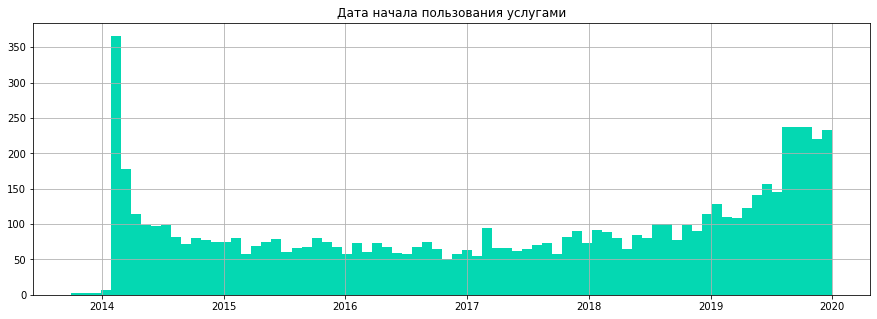

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(df_full['begin_date'], bins=76, color='#04d8b2')
plt.grid()
plt.title('Дата начала пользования услугами') 
plt.show

Первый договор с клиентом в предоставленных нам данных был оформлен в октябре 2013 года. На гистограмме мы видим, что в феврале 2014 года количество заключаемых договоров резко возросло до отметки 350, но уже с лета 2014 по конец 2018 года распределение заключаемых договоров было примерно на одном уровне в промежутке от 50 до 100 штук, а за последний год наблюдений мы вновь видим значительный рост. 

<function matplotlib.pyplot.show(close=None, block=None)>

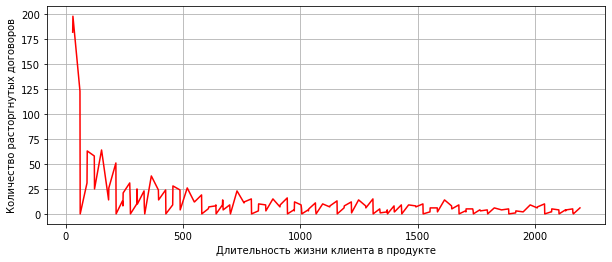

In [ ]:
target_grouped = df_full.groupby('lifetime_days')['target'].sum()

plt.figure(figsize=(10, 4))
plt.plot(target_grouped, color='r')
plt.grid()
plt.xlabel('Длительность жизни клиента в продукте') 
plt.ylabel('Количество расторгнутых договоров')
plt.show

Мы видим, что чаще всего клиенты отказывались от услуг оператора уже после первого месяца использования. А клиенты, пользующиеся услугами уже много лет, значительно реже расторгают договор.

### Способы оплаты, траты на услуги

<function matplotlib.pyplot.show(close=None, block=None)>

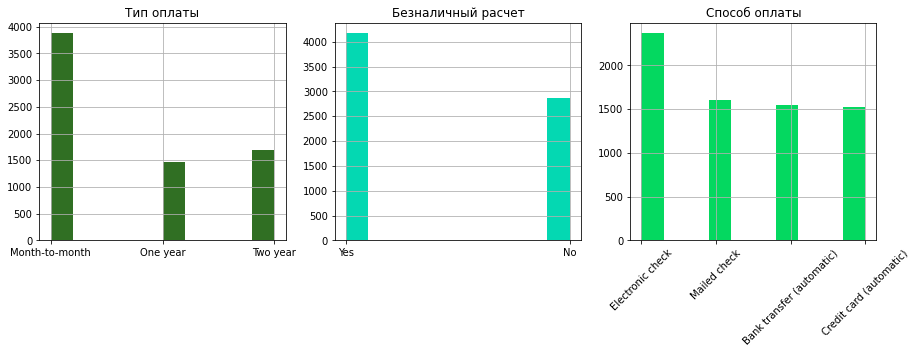

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot (1, 3, 1)
plt.hist(df_full['type'], color='#306f23')
plt.grid()
plt.title('Тип оплаты') 
plt.subplot (1, 3, 2)
plt.hist(df_full['paperless_billing'], color='#04d8b2')
plt.grid()
plt.title('Безналичный расчет') 
plt.subplot (1, 3, 3)
plt.hist(df_full['payment_method'], color='#04d860')
plt.xticks(rotation=45)
plt.grid()
plt.title('Способ оплаты') 
plt.show

Мы видим, что чаще всего клиенты предпочитают ежемесячные платежи за услуги, а также чаще выбирают безналичный тип оплаты. 

Изучим различия в способах оплаты у активных клиентов, и у клиентов, отказавшихся от услуг:

([0, 1, 2, 3],
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

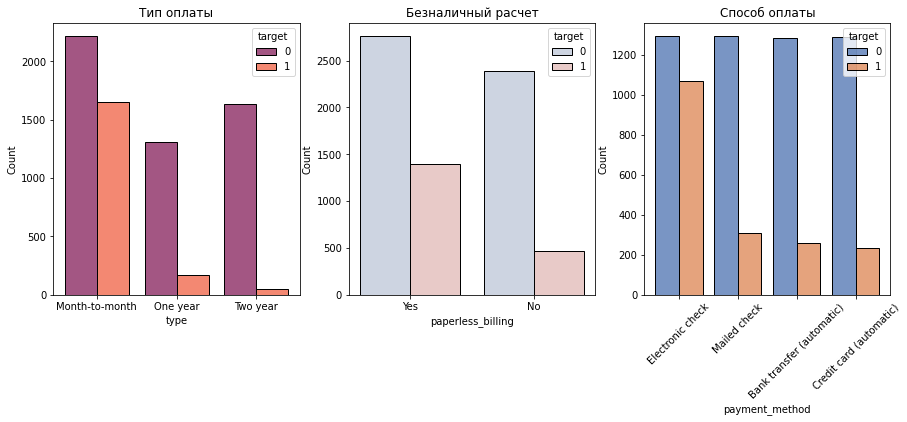

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(
    data=df_full, x='type', hue='target', multiple="dodge", 
    palette="rocket", shrink=.8, ax=ax1
)
ax1.set_title("Тип оплаты")

sns.histplot(
    data=df_full, x='paperless_billing', hue='target', 
    multiple="dodge", palette="vlag", shrink=.8, ax=ax2
)
ax2.set_title("Безналичный расчет")

sns.histplot(
    data=df_full, x='payment_method', hue='target', 
    multiple="dodge", palette="deep", shrink=.8, ax=ax3
)
ax3.set_title("Способ оплаты")
plt.xticks(rotation=45)
plt.show

На графике мы видим, что клиенты с ежемесячной оплатой намного чаще отказываются от услуг, чем клиенты с годовой или двух-годовой подпиской.

Также мы видим, что клиенты с автоматической системой оплаты значительно реже разрывают договор, чем клиенты, оплачивающие счёт вручную.

Сравним меры центральной тенденции ежемесячных трат на услуги у клиентов, отказавшихся от услуг, и у клиентов, которые остались с оператором связи.

In [ ]:
payment_pivot = df_full.pivot_table(
    index='target',
    values='monthly_charges',
    aggfunc=[np.median, np.mean]
)
payment_pivot.round(1)

,median,mean
,monthly_charges,monthly_charges
target,,
0,64.4,61.3
1,79.6,74.4


Мы видим, что у клиентов, расторгнувших договор, средняя и медианная стоимость услуг выше, чем у тех, кто остался с оператором связи.

Изучим общие графики трат на услуги:

<function matplotlib.pyplot.show(close=None, block=None)>

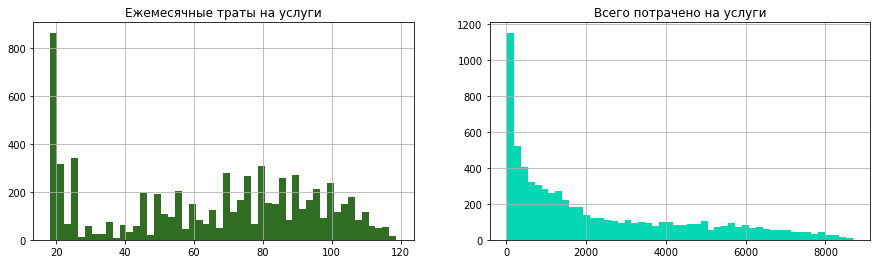

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot (1, 2, 1)
plt.hist(df_full['monthly_charges'], bins=50, color='#306f23')
plt.grid()
plt.title('Ежемесячные траты на услуги') 
plt.subplot (1, 2, 2)
plt.hist(df_full['total_charges'], bins=50, color='#04d8b2')
plt.grid()
plt.title('Всего потрачено на услуги') 
plt.show

На графиках мы видим пикe у минимальной отметки ежемесячных трат на услуги. Посмотрим, какими услугами пользовались клиенты из этой когорты.

In [ ]:
minnows = df_full[df_full['monthly_charges'] <= 30]

print(f'''Клиентов когорты "мальки", пользующихся и интернетом, и телефоном: {sum((minnows['internet_user'] == 'Yes') & (minnows['phone_user'] == 'Yes'))}
Клиентов когорты "мальки", пользующихся интернетом: {sum(minnows['internet_user'] == 'Yes')}
Клиентов когорты "мальки", пользующихся телефоном: {sum(minnows['phone_user'] == 'Yes')} 
Клиентов когорты "мальки", отказавшихся от услуг оператора: {sum(minnows['target'])}, {sum(minnows['target'])/len(minnows):.0%}''')

Клиентов когорты "мальки", пользующихся и интернетом, и телефоном: 0
Клиентов когорты "мальки", пользующихся интернетом: 127
Клиентов когорты "мальки", пользующихся телефоном: 1520 
Клиентов когорты "мальки", отказавшихся от услуг оператора: 162, 10%


Основная часть клиентов среди "мальков" -- пользователи только телефонной сети. Как правило, это самая бюджетная услуга, поэтому никакой аномалии здесь нет. При этом количество пользователей из этой когорты, отказавшихся от услуг оператора за время наблюдения -- всего 10%. 

### Личные данные клиентов

<function matplotlib.pyplot.show(close=None, block=None)>

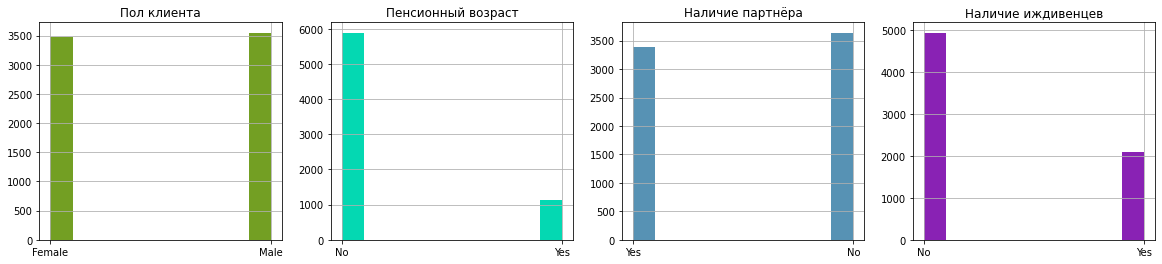

In [ ]:
plt.figure(figsize=(20, 4))
plt.subplot (1, 4, 1)
plt.hist(df_full['gender'], color='#739f23')
plt.grid()
plt.title('Пол клиента') 
plt.subplot (1, 4, 2)
plt.hist(df_full['senior_citizen'], color='#04d8b2')
plt.grid()
plt.title('Пенсионный возраст') 
plt.subplot (1, 4, 3)
plt.hist(df_full['partner'], color='#5792b4')
plt.grid()
plt.title('Наличие партнёра') 
plt.subplot (1, 4, 4)
plt.hist(df_full['dependents'], color='#8922b4')
plt.grid()
plt.title('Наличие иждивенцев') 
plt.show

В предоставленной выборке примерно равное количество мужчин и женщин. Это хорошо для избежания дискриминации при обучении модели. Пенсионеры составляют около 1/7 от общего количества клиентов. Пользователей, имеющих партнёров, чуть меньше, чем холостых, а клиентов, имеющих иждивенцев, всего 30%.

Мы рассмотрим, как эти признаки распределяются у активных и отказавшихся клиентов:

<function matplotlib.pyplot.show(close=None, block=None)>

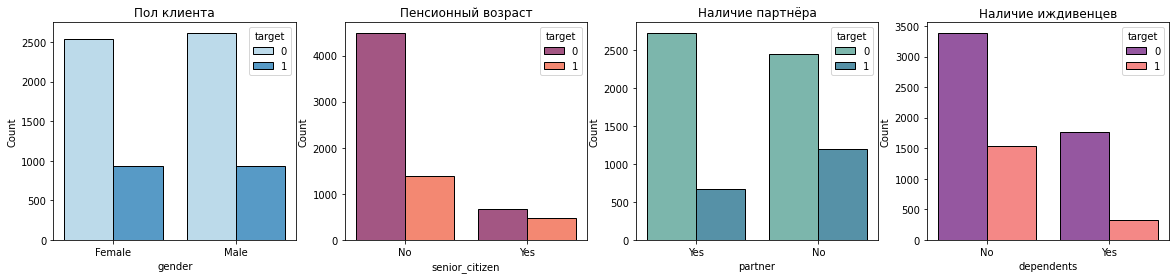

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
sns.histplot(
    data=df_full, x='gender', hue='target', multiple="dodge", 
    palette="Paired", shrink=.8, ax=ax1
)
ax1.set_title('Пол клиента') 

sns.histplot(
    data=df_full, x='senior_citizen', hue='target', multiple="dodge", 
    palette="rocket", shrink=.8, ax=ax2
)
ax2.set_title('Пенсионный возраст') 

sns.histplot(
    data=df_full, x='partner', hue='target', multiple="dodge", 
    palette="crest", shrink=.8, ax=ax3
)
ax3.set_title('Наличие партнёра') 

sns.histplot(
    data=df_full, x='dependents', hue='target', multiple="dodge", 
    palette="magma", shrink=.8, ax=ax4
)
ax4.set_title('Наличие иждивенцев') 
plt.show

В целом, значительных различий в личных данных активных и отказавшихся клиентов мы не наблюдаем. Можно отметить, что в нашей выборке клиенты с наличием иждивенцев менее склонны к оттоку.

### Пользователи интернета и телефона

Клиентов , пользующихся и интернетом, и телефоном: 69%
Клиентов, пользующихся интернетом: 78%
Клиентов, пользующихся телефоном: 90%



<function matplotlib.pyplot.show(close=None, block=None)>

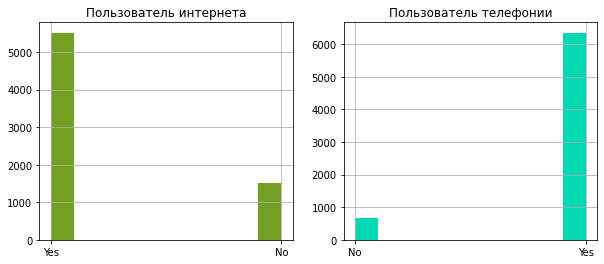

In [ ]:
print(f'''Клиентов , пользующихся и интернетом, и телефоном: {sum((df_full['internet_user'] == 'Yes') & (df_full['phone_user'] == 'Yes'))/len(df_full):.0%}
Клиентов, пользующихся интернетом: {sum(df_full['internet_user'] == 'Yes')/len(df_full):.0%}
Клиентов, пользующихся телефоном: {sum(df_full['phone_user'] == 'Yes')/len(df_full):.0%}''')
print('')
plt.figure(figsize=(10, 4))
plt.subplot (1, 2, 1)
plt.hist(df_full['internet_user'], color='#739f23')
plt.grid()
plt.title('Пользователь интернета') 
plt.subplot (1, 2, 2)
plt.hist(df_full['phone_user'], color='#04d8b2')
plt.grid()
plt.title('Пользователь телефонии')  
plt.show

90% всех клиентов пользуются телефонией, а интернетом - на 12% меньше. И телефон, и интернет подключен у 69% пользователей.

Сравним распределение значений у ушедших и активных клиентов.

Text(0.5, 1.0, 'Пользователь телефонии')

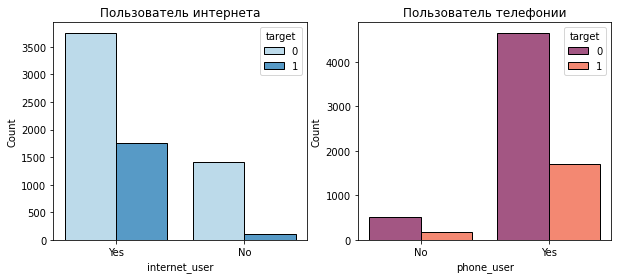

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(
    data=df_full, x='internet_user', hue='target', multiple="dodge", 
    palette="Paired", shrink=.8, ax=ax1
)
ax1.set_title('Пользователь интернета') 

sns.histplot(
    data=df_full, x='phone_user', hue='target', multiple="dodge", 
    palette="rocket", shrink=.8, ax=ax2
)
ax2.set_title('Пользователь телефонии') 
plt.show

Посмотрим в цифрах, сколько пользователей, отказавшихся от услуг, использовали интернет, телефонию или все вместе.

In [ ]:
print(f'''Ушедших клиентов, пользующихся и интернетом, и телефоном: {sum(df_full[(df_full['internet_user'] == 'Yes') & (df_full['phone_user'] == 'Yes')]['target'])}
Ушедших клиентов, пользующихся интернетом: {sum(df_full[df_full['internet_user'] == 'Yes']['target'])}
Ушедших клиентов, пользующихся телефоном: {sum(df_full[df_full['phone_user'] == 'Yes']['target'])}''')

Ушедших клиентов, пользующихся и интернетом, и телефоном: 1586
Ушедших клиентов, пользующихся интернетом: 1756
Ушедших клиентов, пользующихся телефоном: 1699


В нашей выборке пользователи интернета чуть чаще отказываются от услуг, чем пользователи телефонии.  

Рассмотрим поближе, какой тип подключения интернета и телефонии был у ушедших и активных клиентов.



Text(0.5, 1.0, 'Возможность ведения параллельных линий во время звонка')

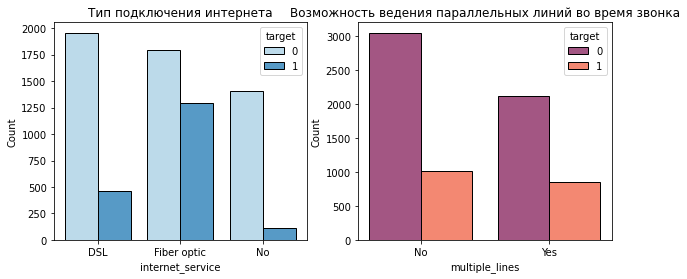

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(
    data=df_full, x='internet_service', hue='target', multiple="dodge", 
    palette="Paired", shrink=.8, ax=ax1
)
ax1.set_title('Тип подключения интернета') 

sns.histplot(
    data=df_full, x='multiple_lines', hue='target', multiple="dodge", 
    palette="rocket", shrink=.8, ax=ax2
)
ax2.set_title('Возможность ведения параллельных линий во время звонка') 
plt.show

Наличие возможности ведения параллельных линий во время звонка не имеет значения, откажется клиент от услуги или нет. 

А на соседнем графике мы видим, что клиенты интернета значительно чаще отказываются от услуг в случае типа подключения Fiber Optic, чем при DSL.

### Отбор признаков для модели

На этом этапе мы отберем необходимые для обучения модели признаки: удалим неинформативные колонки, проверим, как признаки коррелируют с целевым признаком, проверим признаки на мультиколлинеарность.

Начнем с удаления неинформативных столбцов: id клиентов, даты оформления и окончания договора.

In [ ]:
# Удалим неинформативные столбцы
df_full = df_full.drop({'customer_id', 'begin_date', 'end_date'}, axis=1)

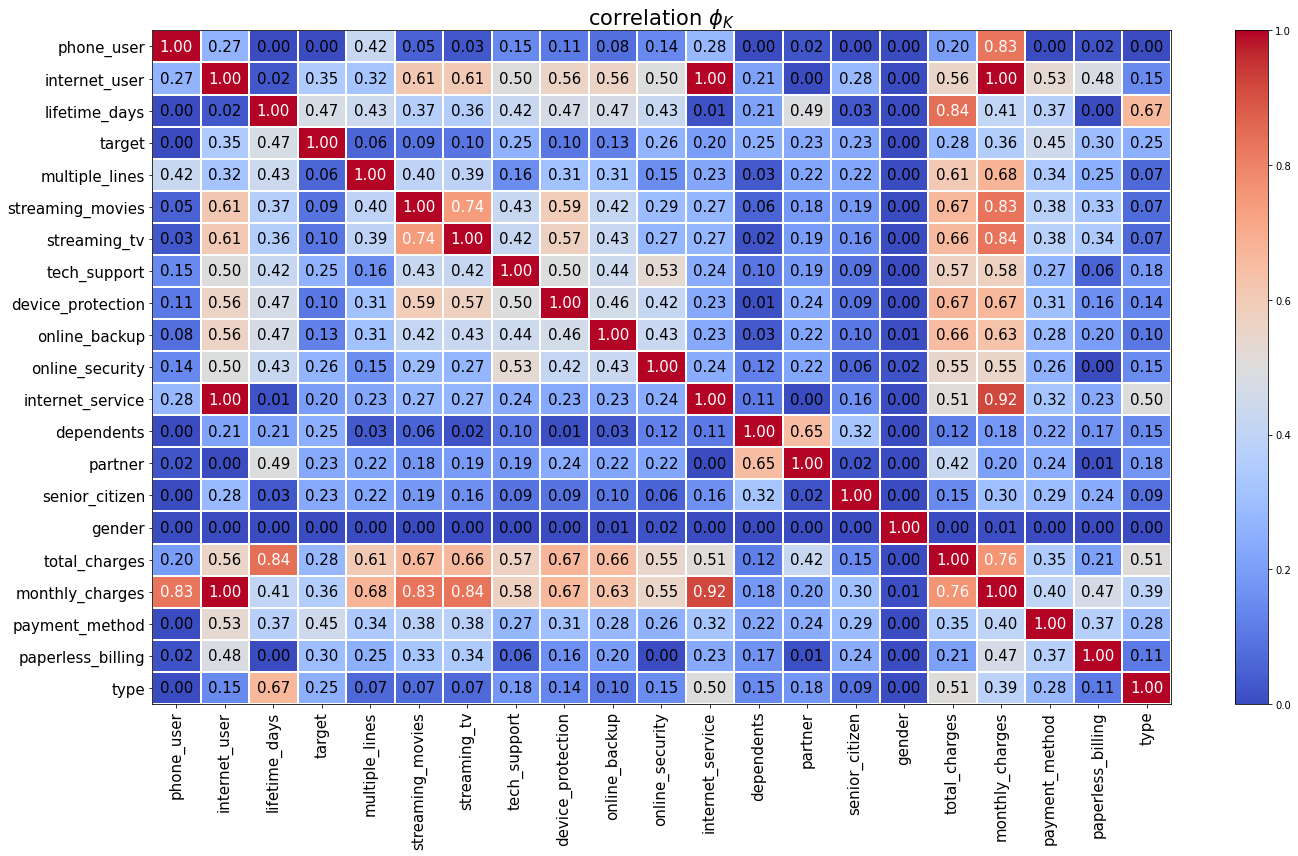

In [ ]:
phik_overview = df_full.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'lifetime_days'])

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

В нашем датасете всего 3 количественных признака: общая сумма списаний, ежемесячная плата, а также количество месяцев использования сервиса клиентом. Все остальные признаки в данных -- категориальные. 

На графике мы видим, что среди количественных признаков между собой достаточно сильно коррелируют общая сумма списаний и количество месяцев использования сервиса (0,84). Между ежемесячным платежом и общей суммой списаний также достаточно сильная корреляция(0,76). В связи с этим, мы исключим признак `total_charges` перед обучением модели.

Между категориальными и количественными признаками мы наблюдаем высокую корреляцию среди признаков:
1. Количество месяцев и тип оплаты (ежемесячный, годовой и тд) (0,67);
2. Ежемесячный платёж достаточно сильно коррелирует с признаками:
*   Пользуется ли клиент телефонией (0,83)
*   Пользуется ли клиент интернетом (1)
*   Со всеми дополнительными услугами интернета, а также наличием возможности ведения параллельных линий во время звонка.

Категориальные признаки, коррелирующие друг с другом:
- Подключение к стриминговому телевидению с подключением к каталогу фильмов;
- Пользуется ли клиент интернетом с интернет-сервисами (что логично, так как признак был сгенерирован из этих данных)

Мы не будем пока что удалять никакие из этих признаков, попробуем обучить машину вместе с ними.

С нашей целевой переменной в значительной степени не коррелирует ни один из признаков. Мы можем наблюдать небольшую корреляцию между количеством месяцев и таргетом (ранее на графике мы видели, что клиенты чаще всего отказываются от услуг уже после первого месяца использования), а также между таргетом и способом оплаты.

Также мы видим, что признак пола клиента практически никак не коррелирует ни с одним из признаков. Пока мы не будем удалять этот признак, попробуем обучить модели вместе с ним, посмотрим, насколько значим этот признак внутри модели.



In [ ]:
# Удалим признак `total_charges`
df_full = df_full.drop('total_charges', axis=1)

## Подготовка признаков для обучения модели

В первую очередь, разделим данные на тренировочную и тестовую выборки. Мы будем проверять модели кросс-валидацией, поэтому валидационная выборка нам не потребуется.



In [ ]:
# Разделим данные на обучающую и тестовую выборки
features = df_full.drop(['target'], axis=1)
target = df_full['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

В нашем исследовании мы обучим 4 модели классификации:
- Логистическая регрессия
- Дерево решений
- Случайный лес
- Градиентный бустинг

Для модели линейной регрессии мы закодируем категориальные признаки методом `OneHotEncoder`, для деревьев -- `OrdinalEncoder`, а для модели бустинга мы будем использовать встроенный способ. Все численные признаки мы будем масштабировать с помощью `StandarScaler`.

Для начала, создадим переменные для категориальных и численных признаков.

In [ ]:
# Создадим переменные для категориальных и численных признаков
cat_columns = [
    'type', 'paperless_billing', 'payment_method', 'gender',
    'senior_citizen', 'partner', 'dependents', 'internet_service',
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies', 'multiple_lines', 'internet_user', 
    'phone_user'
]
num_columns = [
    'monthly_charges', 'lifetime_days'
]

Создадим два трансформера: в первом с кодировка категориальных признаков будет осуществляться методом **OneHotEncoder** во втором -- **OrdinalEncoder**. Оба трансформера также будут масштабировать численные признаки методом StandarScaler

In [ ]:
# Создаем трансформеры с помощью make_column_transformer
ohe_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_columns
    ),
    (
        StandardScaler(), 
        num_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

ordinal_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        cat_columns
    ),
    (
        StandardScaler(), 
        num_columns
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

Данные распределены на обучающую и тестовую выборки, трансформеры для масштабирования и кодирования признаков созданы. Можем переходить к обучению моделей.

## Обучение моделей

В данном исследвании мы обучим следующие модели:
1. Линейные модели:
- Логистическая регрессия
- Ridge Classifier
2. Дерево решений

3. Случайный лес

4. Градиентный бустинг:
- LGBM Classifier
- CatBoost Classifier

Оценку моделей мы будем производить кросс-валидацией с помощью RandomizedSearch + Pipeline. Для этого создадим функцию, которая будет принимать на вход pipeline с моделью и трансформером, а также набор гиперпараметров, а возвращать гиперпараметры лучшей модели и наилучшее значение метрики **AUC-ROC** на обучающей выборке.



In [ ]:
def best_model_and_score(pipe, params):
    rs_pl = RandomizedSearchCV(
        pipe, 
        param_distributions=params, 
        scoring={'AUC': 'roc_auc', 'Accuracy':'accuracy'},
        refit='AUC',
        n_iter=15, cv=3, random_state=RANDOM_STATE,
        n_jobs=-1
    )

    rs_pl.fit(X_train, y_train)

    df_result = pd.DataFrame(rs_pl.cv_results_)
    accuracy = float(
        df_result[
            df_result['mean_test_AUC'] == rs_pl.best_score_
            ]['mean_test_Accuracy'])
 
    # лучшее значение AUC-ROC на кросс-валидации
    print(f'best_score_AUC: {rs_pl.best_score_:0.4f}')
    # лучшее значение Accuracy на кросс-валидации
    print(f'best_score_Accuracy: {accuracy:0.2f}')
    # лучшие гиперпараметры
    print(f'best_params: { rs_pl.best_params_}')
    
    return rs_pl.best_estimator_, rs_pl.best_score_, accuracy

### Линейные модели

Найдем наилучшие гиперпараметры для линейных моделей Ridge Classifier и Логистической регрессии на данных, трансформированных методом OHE.

In [ ]:
# Обучим модель Ridge Classifier на трансформере OHE
model_ridge = RidgeClassifier(random_state=RANDOM_STATE)
pipe_ridge = make_pipeline(ohe_transformer, model_ridge)

param_ridge = {
    'ridgeclassifier__alpha': np.arange(0, 2.0, 0.1),
    'ridgeclassifier__class_weight': [None, 'balanced'],
    'ridgeclassifier__solver': [
        'auto', 'svd', 'cholesky', 'lsqr', 
        'sparse_cg', 'sag', 'saga', 'lbfgs'
        ]
}

best_ridge_model, auc_ridge, acc_ridge = best_model_and_score(
    pipe_ridge, param_ridge
)

best_score_AUC: 0.8420
best_score_Accuracy: 0.74
best_params: {'ridgeclassifier__solver': 'cholesky', 'ridgeclassifier__class_weight': 'balanced', 'ridgeclassifier__alpha': 1.0}


In [ ]:
# Обучим модель Логистической регрессии на трансформере OHE
model_lr = LogisticRegression(random_state=RANDOM_STATE)
pipe_lr = make_pipeline(ohe_transformer, model_lr)
param_lr = {
    'logisticregression__C': (range(1, 15, 3)), 
    'logisticregression__penalty': ('l1', 'l2', 'elasticnet', None), 
    'logisticregression__class_weight': ['balanced', None]
}

best_lr_model, auc_lr, acc_lr = best_model_and_score(
    pipe_lr, param_lr
)

best_score_AUC: 0.8430
best_score_Accuracy: 0.81
best_params: {'logisticregression__penalty': 'l2', 'logisticregression__class_weight': None, 'logisticregression__C': 4}


### Дерево решений

Найдем наилучшие гиперпараметры для модели Дерева решений, обученной на данных, трансформированных методом Ordinal Encoder, а затем подберем гиперпараметры для этой же модели, но обученной на данных, трансформированных методом OHE.

In [ ]:
# Обучим модель Дерево решений на трансформере Ordinal Encoder

model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipe_ord_dtc = make_pipeline(ordinal_transformer, model_dtc)

param_dtc = {
    'decisiontreeclassifier__class_weight': ['balanced', None],
    'decisiontreeclassifier__min_samples_split': range(1, 101, 5),
    'decisiontreeclassifier__max_depth': [1, 5, 7, 10, 15, 20, 30, 40, None],
    'decisiontreeclassifier__min_samples_leaf': range(2, 52, 5),
    'decisiontreeclassifier__max_leaf_nodes': range(5, 100, 10)
}

best_dtc_ord_model, auc_dtc_ord, acc_dtc_ord = best_model_and_score(
    pipe_ord_dtc, param_dtc
)

best_score_AUC: 0.8450
best_score_Accuracy: 0.81
best_params: {'decisiontreeclassifier__min_samples_split': 16, 'decisiontreeclassifier__min_samples_leaf': 47, 'decisiontreeclassifier__max_leaf_nodes': 45, 'decisiontreeclassifier__max_depth': 40, 'decisiontreeclassifier__class_weight': None}


In [ ]:
# Обучим модель Дерево решений на трансформере OHE
pipe_ohe_dtc = make_pipeline(ohe_transformer, model_dtc)

best_dtc_ohe_model, auc_ohe_dtc, acc_ohe_dtc = best_model_and_score(
    pipe_ohe_dtc, param_dtc
)

best_score_AUC: 0.8468
best_score_Accuracy: 0.81
best_params: {'decisiontreeclassifier__min_samples_split': 41, 'decisiontreeclassifier__min_samples_leaf': 17, 'decisiontreeclassifier__max_leaf_nodes': 85, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__class_weight': None}


### Случайный лес

Теперь подберем наилучшие параметры для модели Случайного леса. Также обучим модель на данных, трансформированных двумя способами.

In [ ]:
# Обучим модель Случайного леса на трансформере Ordinal Encoder

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
pipe_ord_rfc = make_pipeline(ordinal_transformer, model_rfc)

param_rfc = {
    'randomforestclassifier__class_weight': ['balanced', None],
    'randomforestclassifier__max_depth': [1, 5, 7, 10, 15, 20, 30, 40, None],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__min_samples_leaf': range(2, 52, 2),
    'randomforestclassifier__min_samples_split': range(2, 52, 5),
    'randomforestclassifier__n_estimators': range(5, 151, 10)
}

best_rfc_ord_model, auc_ord_rfc, acc_ord_rfc = best_model_and_score(
    pipe_ord_rfc, param_rfc
)

best_score_AUC: 0.8593
best_score_Accuracy: 0.79
best_params: {'randomforestclassifier__n_estimators': 105, 'randomforestclassifier__min_samples_split': 22, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__class_weight': 'balanced'}


In [ ]:
# Обучим модель Случайного леса на трансформере OHE
pipe_ohe_rfc = make_pipeline(ohe_transformer, model_rfc)

best_rfc_ohe_model, auc_ohe_rfc, acc_ohe_rfc = best_model_and_score(
    pipe_ohe_rfc, param_rfc
)

best_score_AUC: 0.8557
best_score_Accuracy: 0.81
best_params: {'randomforestclassifier__n_estimators': 135, 'randomforestclassifier__min_samples_split': 47, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__class_weight': None}


### Градиентный бустинг

Для начала подберем модель Градиентного бустинга LGBM Classifier, обученной на данных, закодированных методом OHE.

In [ ]:
# Обучим модель Градиентного бустинга LGBM Classifier

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
pipe_lgbm = make_pipeline(ohe_transformer, model_lgbm)

param_lgbm = {
    'lgbmclassifier__class_weight': ['balanced', None],
    'lgbmclassifier__max_depth': [1, 4, 5, 15, 20, None],
    'lgbmclassifier__n_estimators': range(10, 301, 40)
}

best_lgbm_ohe_model, auc_ohe_lgbm, acc_ohe_lgbm = best_model_and_score(
    pipe_lgbm, param_lgbm
)

best_score_AUC: 0.8921
best_score_Accuracy: 0.84
best_params: {'lgbmclassifier__n_estimators': 290, 'lgbmclassifier__max_depth': 4, 'lgbmclassifier__class_weight': None}


Теперь подберем параметры для модели Градиентного бустинга CatBoost Classifier: для начала мы не будем кодировать данные вовсе -- в CatBoost есть встроенный метод. А затем попробуем подобрать параметры и оценить модель CatBoost, обученной на закодированных данных с помощью OHE.

In [ ]:
# Обучим модель Градиентного бустинга CatBoost Classifier на встроенном способе кодирования

model_cbc = CatBoostClassifier(
    logging_level='Silent', 
    cat_features = cat_columns,
    random_state=RANDOM_STATE)
param_cbc = {
    'depth': [None, 4, 7, 10],
    'learning_rate' : [0.01, 0.04, 0.1],
    'iterations' : [10, 30, 50, 70, 100, 120]
}

best_cbc_model, auc_cbc, acc_cbc = best_model_and_score(
    model_cbc, param_cbc
)

best_score_AUC: 0.8709
best_score_Accuracy: 0.83
best_params: {'learning_rate': 0.1, 'iterations': 120, 'depth': 4}


In [ ]:
# Обучим модель Градиентного бустинга CatBoost Classifier на трансформере OHE
model_cbc = CatBoostClassifier(
    logging_level='Silent', 
    random_state=RANDOM_STATE)

pipe_cbc = make_pipeline(ohe_transformer, model_cbc)

param_cbc_ohe = {
    'catboostclassifier__depth': [4, 7, 10],
    'catboostclassifier__learning_rate' : [0.01, 0.04, 0.1],
    'catboostclassifier__iterations' : [10, 30, 50, 70, 100, 120]
}

best_cbc_ohe_model, auc_ohe_cbc, acc_ohe_cbc = best_model_and_score(
    pipe_cbc, param_cbc_ohe
)

best_score_AUC: 0.8771
best_score_Accuracy: 0.83
best_params: {'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__iterations': 100, 'catboostclassifier__depth': 4}


## Анализ моделей

In [ ]:
colm = ['best_score_AUC', 'best_score_Accuracy']
ind = [
    'Ridge Classifier on OHE', 'Logistic Regression on OHE',
    'Decision Tree on Ordinal Encoder', 'Decision Tree on OHE',
    'Random Forest on Ordinal Encoder', 'Random Forest on OHE',
    'LGBM Classifier on OHE', 'CatBoost Classifier', 
    'CatBoost Classifier on OHE'      
    ]

val = [[auc_ridge, acc_ridge],
       [auc_lr, acc_lr],
       [auc_dtc_ord, acc_dtc_ord],
       [auc_ohe_dtc, acc_ohe_dtc],
       [auc_ord_rfc, acc_ord_rfc],
       [auc_ohe_rfc, acc_ohe_rfc],
       [auc_ohe_lgbm, acc_ohe_lgbm],
       [auc_cbc, acc_cbc],
       [auc_ohe_cbc, acc_ohe_cbc]
       ]

df_total_scores = pd.DataFrame(data=val, index=ind, columns=colm)
df_total_scores.sort_values('best_score_AUC', ascending=False).style.background_gradient(axis=0, cmap='YlOrRd')

,best_score_AUC,best_score_Accuracy
LGBM Classifier on OHE,0.892066,0.844520
CatBoost Classifier on OHE,0.877089,0.830489
CatBoost Classifier,0.870852,0.827835
Random Forest on Ordinal Encoder,0.859345,0.794463
Random Forest on OHE,0.855694,0.808115
Decision Tree on OHE,0.846796,0.811528
Decision Tree on Ordinal Encoder,0.845005,0.807167
Logistic Regression on OHE,0.843012,0.805461
Ridge Classifier on OHE,0.841987,0.742890


Наилучший результат **метрики AUC-ROC** на обучающей выборке показала модель градиентного бустинга **LGBM Classifier** на трансформере One Hot Encoder. 

- Значение метрики **AUC-ROC** лучшей модели: **0.8921**
- Значение метрики **Accuracy** лучшей модели: **0.84**
- **Параметры** модели: `n_estimators=290, max_depth=4, class_weight=None`



На втором месте - также модель градиентного бустинга **CatBoost Classifier**, также обученная на трансформированных данных с помощью One Hot Encoder. На третьем месте -- **Случайный лес**, обученный на трансформированных данных с помощью Ordinal Encoder.

Значение второй метрики, **Accuracy**, самое высокое также у модели бустинга **LGBM Classifier**. По всем показателям эта модель показала наилучший результат на обучающей выборке, поэтому тестовые данные мы будем проверять на ней. 

## Тестирование модели



In [ ]:
# Обучаем лучшую модель на тренировочной выборке
best_lgbm_ohe_model.fit(X_train, y_train)
predict_test = best_lgbm_ohe_model.predict(X_test)
probabilities_test = best_lgbm_ohe_model.predict_proba(X_test)[:, 1]

In [ ]:
print(f'Площадь под ROC-кривой: {roc_auc_score(y_test, probabilities_test):.2f}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, predict_test):.2f}')

Площадь под ROC-кривой: 0.91
Accuracy на тестовой выборке: 0.86


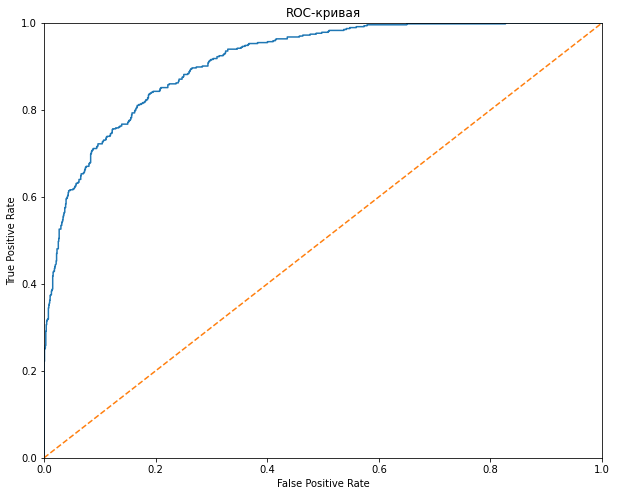

In [ ]:
# Визуализируем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На тестовой выборке модель достигла показателя 0.91, что превышает поставленный заказчиком порог. 

## Отчет по работе

В проведённом исследовании мы проделали следующие шаги:  



### 1. Загрузили и изучили предоставленные данные.

Прочитали предоставленные файлы, сохранили их в переменные:
- `df_contract` — информация о договоре;
- `df_personal` — персональные данные клиента;
- `df_internet` — информация об интернет-услугах;
- `df_phone` — информация об услугах телефонии.

После чего изучили данные в каждой таблице:
- Получили общую информацию о таблице;
- Вывели на экран первые 5 строк таблицы;
- Получили числовое описание данных в таблице.

В ходе первичного обзора данных мы выявили следующие проблемы:
- В данных присутствовали пропуски (так как количество строк в датасетах разное);
- У некоторых признаков был указан неверный тип данных; 
- Присутствует нарушение стиля в названии признаков;


### 2. Произвели предобработку данных.

Объединили все датафреймы в один общий по индексу `customerID`.

Проверили таблицу на полные дубликаты (они отсутствуют).

Изменили наименования колонок, согласно правилам хорошего стиля.

Рассмотрели каждый признак по отдельности:

*Дата начала и окончания пользования услугами.*
- В колонке с датой начала пользования услугами изменили тип данных на `datetime`;
- Выделили из даты окончания пользования услугами целевую переменную `target`: там, где присутствует дата расторжения договора, мы установили значение 1 (True), где заглушка - 0 (False);
- Заменили заглушку на дату сбора данных;
- Заменили тип данных на `datetime`;
- Выделили новый признак  -- сколько дней пользователь является клиентом оператора связи.

*Типы и методы оплат*
- В типах данных и методах оплат проблем не оказалось
- В колонке с ежемесячной суммой к оплате все указано верно, пропусков или аномалий нет;
- В колонке с общей суммой, потраченной на услуги, обнаружены пропуски -- строки с новыми клиентами, которые еще не производили оплату. Так как количество этих строк было небольшим, мы исключили их из общей выборки.
- Заменили тип данных в колонке `total_charges` на `float`.

*Персональные данные клиента*
- Привели значения признака *Пенсионный возраст* к типу `object`, аналогичному другим бинарным категориальным признакам.

*Интернет-услуги и телефония*
- Добавили дополнительный признак: является клиент пользователем интернета или нет. Если id клиента было в таблице с информацией об интернет-услугах -- значит клиент пользовался интернетом (так как в первоначальном датасете с информацией об интернет-услугах пропусков не было);
- Аналогичным образом создадали колонку с информацией, является ли клиент пользователем телефонии;
- Так как данные пропущены в признаках бинарной классификации, в которых указано, пользуется ли клиент той или иной услугой, мы заменим все пропуски в данных на `No`.

**По итогу предобработки данных мы:**
- Объеденили предоставленные датасеты в один общий датафрейм;
- Сгенерировали целевую переменную;
- Исправили тип данных там, где это было нужно;
- Заполнили пропущенные значения;
- Сгенерировали дополнительные признаки.


### 3. Провели исследовательский анализ данных.

*Изучили жизнь клиента в продукте.*  

Изучили, в какие годы клиенты заключали договор: первый договор с клиентом в предоставленных нам данных был оформлен в октябре 2013 года. На гистограмме мы видим, что в феврале 2014 года количество заключаемых договоров резко возросло до отметки 350, но уже с лета 2014 по конец 2018 года распределение заключаемых договоров было примерно на одном уровне в промежутке от 50 до 100 штук, а за последний год наблюдений мы вновь видим значительный рост.

Построили график, на котором отобразили, на каком сроке жизни клиента в продукте чаще всего расторгался договор: чаще всего клиенты отказывались от услуг оператора уже после первого месяца использования. А клиенты, пользующиеся услугами уже много лет, значительно реже расторгают договор.

*Способы оплаты, траты на услуги.*  

На общей выборке мы увидели, что чаще всего клиенты предпочитают ежемесячные платежи за услуги, а также чаще выбирают безналичный тип оплаты.

Изучили различия в способах оплаты у активных клиентов, и у клиентов, отказавшихся от услуг: клиенты с ежемесячной оплатой намного чаще отказываются от услуг, чем клиенты с годовой или двух-годовой подпиской.
Также клиенты с автоматической системой оплаты значительно реже разрывают договор, чем клиенты, оплачивающие счёт вручную.

Сравнили меры центральной тенденции ежемесячных трат на услуги у клиентов, отказавшихся от услуг, и у клиентов, которые остались с оператором связи: у клиентов, расторгнувших договор, медианная и средняя стоимость услуг выше, чем у тех, кто остался с оператором связи.

Изучили общие графики трат на услуги: отметили пики у минимальной отметки ежемесячных и общих трат на услуги.

Поближе изучили поведение клиентов из когорты "мальки" (клиенты с самым минимальным ежемесячным платежом): Основная часть клиентов -- пользователи только телефонной сети. Как правило, это самая бюджетная услуга, поэтому никакой аномалии здесь нет. При этом количество пользователей из этой когорты, отказавшихся от услуг оператора за время наблюдения -- всего 10%. 

*Личные данные клиентов*

В выборке примерно равное количество мужчин и женщин. Это хорошо для избежания дискриминации при обучении модели.

Пенсионеры составляют около 1/7 от общего количества клиентов. 

Пользователей, имеющих партнёров, чуть меньше, чем холостых.

Клиентов, имеющих иждивенцев, всего 30%. При этом клиенты, имеющие иждивенцев, реже отказываются от услуг.

*Пользователи интернета и телефона*

- Клиентов, пользующихся и интернетом, и телефоном: 69%
- Клиентов, пользующихся интернетом: 78%
- Клиентов, пользующихся телефоном: 90%

В нашей выборке пользователи интернета чуть чаще отказываются от услуг, чем пользователи телефонии.

Наличие возможности ведения параллельных линий во время звонка не имеет значения, откажется клиент от услуги или нет. При этом клиенты интернета значительно чаще отказываются от услуг, в случае типа подключения Fiber Optic, чем при DSL.

**Отобрали признаки для модели**
Исключили неинформативные столбцы: id клиентов, даты оформления и окончания договора.

Построили график корреляции Фk:
- Среди количественных признаков между собой сильно коррелируют общая сумма списаний и количество месяцев использования сервиса (0,84). Между ежемесячным платежом и общей суммой списаний также достаточно сильная корреляция(0,76). **В связи с этим, мы исключили признак `total_charges` перед обучением модели.**
- Между категориальными и количественными признаками мы наблюдаем высокую корреляцию среди признаков:
  - Количество месяцев и тип оплаты (ежемесячный, годовой и тд) (0,67);
  - Ежемесячный платёж достаточно сильно коррелирует с признаками:
    - Пользуется ли клиент телефонией (0,83)
    - Пользуется ли клиент интернетом (1)
    - Со всеми дополнительными услугами интернета, а также наличием возможности ведения параллельных линий во время звонка.
- Категориальные признаки, коррелирующие друг с другом:
  - Подключение к стриминговому телевидению с подключением к каталогу фильмов;
  - Пользуется ли клиент интернетом с интернет-сервисами (что логично, так как признак был сгенерирован из этих данных)
 
Мы не исключали никакие из этих признаков.

С нашей целевой переменной в значительной степени не коррелирует ни один из признаков. Мы можем наблюдать небольшую корреляцию между количеством месяцев и таргетом (ранее на графике мы видели, что клиенты чаще всего отказываются от услуг уже после первого месяца использования), а также между таргетом и способом оплаты.

Также мы видим, что признак пола клиента практически никак не коррелирует ни с одним из признаков. Пока мы не будем удалять этот признак, попробуем обучить модели вместе с ним, посмотрим, насколько значим этот признак внутри модели.

### 4. Подготовили признаки для обучения модели

На обучение модели мы отобрали следующие признаки:

Категориальные признаки: 
`'type', 'paperless_billing', 'payment_method', 'gender',
 'senior_citizen', 'partner', 'dependents', 'internet_service',
 'online_security', 'online_backup', 'device_protection', 'tech_support',
 'streaming_tv', 'streaming_movies', 'multiple_lines', 'internet_user', 
 'phone_user' `

Численные признаки: 
`'monthly_charges', 'lifetime_days'`

**В данном проекте мы используем константу** `RANDOM_STATE = 270223`. 

Мы проделали следующие шаги:

- Разделили данные на тренировочную и тестовую выборки. **Размер тестовой выборки: test_size = 0.25**
- Создали переменные для категориальных и численных признаков.
- Создали два трансформера: в первом кодировка категориальных признаков осуществляется методом **OneHotEncoder** во втором -- **OrdinalEncoder**. Оба трансформера также масштабируют численные признаки методом **StandarScaler**.


### 5. Обучили модели, подбирая различные гиперпараметры
В данном исследвании мы обучили следующие модели:
- Линейные модели:
 - Логистическая регрессия
 - Ridge Classifier
- Дерево решений
- Случайный лес
- Градиентный бустинг:
 - LGBM Classifier
 - CatBoost Classifier

Оценку моделей мы производили кросс-валидацией с помощью RandomizedSearch + Pipeline. Для этого создали функцию, которая принимает на вход pipeline с моделью и трансформером, а также набор гиперпараметров, а возвращает гиперпараметры лучшей модели и наилучшее значение метрики AUC-ROC на обучающей выборке.

### 6. Проанализировали результат обучения моделей, отобрали лучшую

Наилучший результат метрики **AUC-ROC** на обучающей выборке показала модель градиентного бустинга **LGBM Classifier** на трансформере **One Hot Encoder**.

**Лучшая модель:**  
`LGBMClassifier(random_state=RANDOM_STATE, n_estimators=290, max_depth=4, class_weight=None)`

Значение метрики **AUC-ROC** лучшей модели: **0.8921**  
Значение метрики **Accuracy** лучшей модели: **0.84**  

На втором месте - также модель градиентного бустинга, CatBoost Classifier, также обученная на трансформированных данных с помощью One Hot Encoder. На третьем месте -- CatBoost Classifier на встроенном способе кодирования, на четвёртом -- Случайный лес, обученный на трансформированных данных с помощью Ordinal Encoder.

Значение второй метрики, Accuracy, самое высокое также у модели бустинга LGBM Classifier. 

По всем показателям эта модель показала наилучший результат на обучающей выборке, поэтому тестовые данные мы проверяли на ней.


### 7. Протестировали отобранную модель на тестовой выборке

На тестовой выборке отобранная модель показала следующий результат:

**Площадь под ROC-кривой: 0.91**  
**Accuracy на тестовой выборке: 0.86**

Значения метрик на тестовой выборке даже выше, чем на кросс-валидации. 


### Вывод

В ходе данного исследования мы придерживались изначально составленного плана. Все пункты плана были выполнены в полном объеме.

Трудностей в решении задач не возникло.

Все шаги данного исследования были ключевыми. В особенности можно выделить этап предобработки данных: на этом шаге мы выделили целевую переменную, подготовили данные к обучению, а также создали важные для обучения моделей признаки.   
На этапе исследовательского анализа данных мы отобрали необходимые признаки для обучения моделей, отбросив неинформативные и мультиколлинеарные признаки. 
На этапе обучения моделей мы подобрали наилучший вариант. Тестирование отобранной модели прошло успешно: поставленный заказчиком порог целевой метрики был преодолен.

Проведённое исследование можно считать успешным.